# DS - Healthcare - Persistency of a drug

-   Problem understanding
-   Data Understanding
-   Data Cleaning and Feature engineering
-   Model Development
-   Model Selection
-   Model Evaluation
-   Report the accuracy, precision and recall of both the class of target variable
-   Report ROC-AUC as well
-   Deploy the model
-   Explain the challenges and model selection

In [ ]:
import sys
import random
import pickle
from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from copy import deepcopy
import matplotlib.pyplot as plt

from scipy.spatial import distance, ConvexHull
from scipy.sparse import coo_matrix, hstack, csr_matrix

import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

import keras
from keras import callbacks
import tensorflow as tf


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

mpl.rcParams['font.sans-serif'] = ['SimHei']
%matplotlib inline
# %matplotlib notebook
sns.set()

# for google drive, uncommenct them if not drive
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/DataGlacier_FP')

%cd /content/drive/My Drive/DataGlacier_FP/

from preprocess import *

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DataGlacier_FP
corr.csv     Docs	Healthcare_dataset.xlsx  preprocess.py
Dataset.csv  EDA.ipynb	Model.ipynb		 __pycache__


# Read Data

In [ ]:
dict_df = pd.read_excel('Healthcare_dataset.xlsx', sheet_name=['Feature Description','Dataset'])

df_fd=dict_df.get('Feature Description').fillna(method="ffill")
raw_df=dict_df['Dataset'].drop('Ptid',axis=1)

print(raw_df.shape)

(3424, 68)


In [ ]:
raw_df[label].value_counts()

# Feature Engineering

In [ ]:
colnames=raw_df.columns
label='Persistency_Flag'
inde_colnames=[col for col in colnames if col !=label]

X=[]
str_colnames=[]
for col in colnames:
    if raw_df[col].dtype=='object':
        str_colnames.append(col)
    else:
        num_colnames.append(col)

print('string colnames:',str_colnames)
print('number colnames:',num_colnames)

string colnames: ['Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure', 'Comorb_Disor

In [ ]:
df,map_cs=hard_code(raw_df,str_colnames)

In [ ]:
df.describe()

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
count,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,...,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000,3424.000000
mean,0.376460,0.056659,1.948306,0.997956,1.781834,1.674942,13.590537,0.412091,0.967290,0.235105,...,0.104556,0.012266,0.477804,0.056075,0.019568,0.015771,0.003213,0.004089,0.020152,1.239486
std,0.484568,0.231223,0.401520,0.234969,1.608482,1.220050,11.932789,0.492283,0.620126,0.424126,...,0.306025,0.110088,0.499580,0.230100,0.138530,0.124607,0.056597,0.063822,0.140540,1.094914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000,1.000000,3.000000,1.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,2.000000,1.000000,3.000000,3.000000,30.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,1.000000,3.000000,2.000000,4.000000,3.000000,35.000000,1.000000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [ ]:
df.head()

,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,Gluco_Record_Prior_Ntm,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,1,1,2,1,4,3,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,4,0,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,0,1,5,0,1,0,...,0,1,0,0,0,0,0,0,0,2
3,0,0,2,1,0,3,5,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,2,1,0,3,5,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df["log_Dexa_Freq_During_Rx"]=np.log(1+df["Dexa_Freq_During_Rx"]);


## capping
thre=10 # 30
df["cap_Dexa_Freq_During_Rx"]=df["Dexa_Freq_During_Rx"]
df["cap_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] >= thre] = thre


df["drop0_Dexa_Freq_During_Rx"]=df["Dexa_Freq_During_Rx"]
df["drop0_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] == 0] = None

df["drop0_Dexa_Freq_During_Rx"][df["Dexa_Freq_During_Rx"] >= 30] = 30


## bin
# pd.qcut(df['Dexa_Freq_During_Rx'], q=[0,])
df['bin_Dexa_Freq_During_Rx']=pd.cut(df['Dexa_Freq_During_Rx'], bins=[0, 1, 5, 8, 15, 27,150], right=False)

scalar=MinMaxScaler()
temp=["Dexa_Freq_During_Rx","log_Dexa_Freq_During_Rx", "cap_Dexa_Freq_During_Rx"]
df[temp]=scalar.fit_transform(df[temp])

concom_pca_dims = PCA(n_components=2, random_state=265).fit_transform(df[concom_colnames])
df["concom_pca_dim_1"] = concom_pca_dims[:, 0]
df["concom_pca_dim_2"] = concom_pca_dims[:, 1]

comorb_pca_dims = PCA(n_components=2, random_state=265).fit_transform(df[comorb_colnames])
df["comorb_pca_dim_1"] = comorb_pca_dims[:, 0]
df["comorb_pca_dim_2"] = comorb_pca_dims[:, 1]

risk_pca_dims = PCA(n_components=2, random_state=265).fit_transform(df[risk_colnames])
df["risk_pca_dim_1"] = risk_pca_dims[:, 0]
df["risk_pca_dim_2"] = risk_pca_dims[:, 1]

In [ ]:
dexa_colnames=['Dexa_During_Rx']+["Dexa_Freq_During_Rx","log_Dexa_Freq_During_Rx", "cap_Dexa_Freq_During_Rx", "drop0_Dexa_Freq_During_Rx",'bin_Dexa_Freq_During_Rx' ]

demog_colnames=[ 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket','Idn_Indicator']

provider_colnames=[c for c in colnames if c.startswith("Ntm")]

frag_colnames=[c for c in colnames if c.startswith("Frag")]
gluco_colnames=[c for c in colnames if c.startswith("Gluco")]
tscore_colnames=[c for c in colnames if c.startswith("Tscore")]+["Change_T_Score"]
clinical_colnames=frag_colnames+gluco_colnames+tscore_colnames


other_disease_colnames=["Adherent_Flag","Injectable_Experience_During_Rx"]
concom_colnames=[c for c in colnames if c.startswith("Concom")]
comorb_colnames=[c for c in colnames if c.startswith("Comorb")]
risk_colnames=[c for c in colnames if c.startswith("Risk")]
disease_colnames=other_disease_colnames+concom_colnames+comorb_colnames+risk_colnames

# Train

In [ ]:
def visualize_cm(matrix):
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(10,6))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ["Non-Persistent","Persistent"]
    tick_marks = np.arange(len(class_names))+0.5
    tick_marks2 = tick_marks
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix for Random Forest Model')
    plt.show()

In [ ]:
def generate_accs(model, X_train, y_train, X_test, y_test, show=True):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    if show: print(f"train set acc: {train_acc} test set acc: {test_acc}")
    return train_acc, test_acc

In [ ]:
def plot_feature_importances(model):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=model.feature_names_in_).sort_values(ascending=False)


    fig, ax = plt.subplots() #figsize=(16,16)
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [ ]:
# test_size=0.2
# X=df[inde_colnames]
# y=raw_df[label]

def model_train(X):

    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=265)

    kwargs={
        'criterion' :'entropy',
        'n_estimators':100,
        'n_jobs':-1,
        'max_depth':15,
        'random_state':265}

    rf=RandomForestClassifier(**kwargs)

    rf.fit(X_train,y_train)

    y_pred=rf.predict(X_test)

    generate_accs(rf,X_train, y_train, X_test, y_test)

    show=True
    cm = confusion_matrix(y_test, y_pred)
    if show:
        print(f"\nConfusion matrix: \n{cm}")
        print(classification_report(y_test, y_pred)) # , target_names=class_names

    visualize_cm(cm)

    print("="*58)

    return rf

In [ ]:
def model_train_cv(X,model,param_grid):
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_size, random_state=265)

    grid_clf = GridSearchCV(model, param_grid, cv=10)
    grid_clf.fit(X_train, y_train)

    best_model=grid_clf.best_estimator_
    print(grid_clf.best_params_)

    y_pred=best_model.predict(X_test)

    generate_accs(best_model,X_train, y_train, X_test, y_test)

    show=True
    cm = confusion_matrix(y_test, y_pred)
    if show:
        print(f"\nConfusion matrix: \n{cm}")
        print(classification_report(y_test, y_pred)) # , target_names=class_names

    visualize_cm(cm)

    print("="*58)

    return best_model

In [ ]:
dexa_colnames=['Dexa_During_Rx']+["log_Dexa_Freq_During_Rx"]

demog_colnames=[ 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket','Idn_Indicator']

provider_colnames=["Ntm_Speciality_Bucket","Ntm_Specialist_Flag"]

frag_colnames=["Frag_Frac_During_Rx"]
gluco_colnames=["Gluco_Record_During_Rx"]
tscore_colnames=["Tscore_Bucket_During_Rx"]
clinical_colnames=frag_colnames+gluco_colnames+tscore_colnames


other_disease_colnames=["Adherent_Flag","Injectable_Experience_During_Rx"]

concom_colnames=["concom_pca_dim_1","concom_pca_dim_2"]
comorb_colnames=["comorb_pca_dim_1","comorb_pca_dim_2"]
risk_colnames=["risk_pca_dim_1","risk_pca_dim_2"]
disease_colnames=other_disease_colnames+concom_colnames+comorb_colnames+risk_colnames

inde_colnames_1=dexa_colnames+demog_colnames+provider_colnames+clinical_colnames+disease_colnames

In [ ]:
dexa_colnames=['Dexa_During_Rx']+["log_Dexa_Freq_During_Rx"]

demog_colnames=[ 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket','Idn_Indicator']

provider_colnames=["Ntm_Speciality_Bucket","Ntm_Specialist_Flag"]

frag_colnames=["Frag_Frac_During_Rx"]
gluco_colnames=["Gluco_Record_During_Rx"]
tscore_colnames=["Tscore_Bucket_During_Rx"]
clinical_colnames=frag_colnames+gluco_colnames+tscore_colnames


other_disease_colnames=["Adherent_Flag","Injectable_Experience_During_Rx"]
concom_colnames=[c for c in colnames if c.startswith("Concom")]
comorb_colnames=[c for c in colnames if c.startswith("Comorb")]
risk_colnames=[c for c in colnames if c.startswith("Risk")]

disease_colnames=other_disease_colnames+concom_colnames+comorb_colnames+risk_colnames

inde_colnames_2=dexa_colnames+demog_colnames+provider_colnames+clinical_colnames+disease_colnames

train set acc: 0.9784592917123037 test set acc: 0.8277372262773722

Confusion matrix: 
[[379  39]
 [ 79 188]]
                precision    recall  f1-score   support

Non-Persistent       0.83      0.91      0.87       418
    Persistent       0.83      0.70      0.76       267

      accuracy                           0.83       685
     macro avg       0.83      0.81      0.81       685
  weighted avg       0.83      0.83      0.82       685



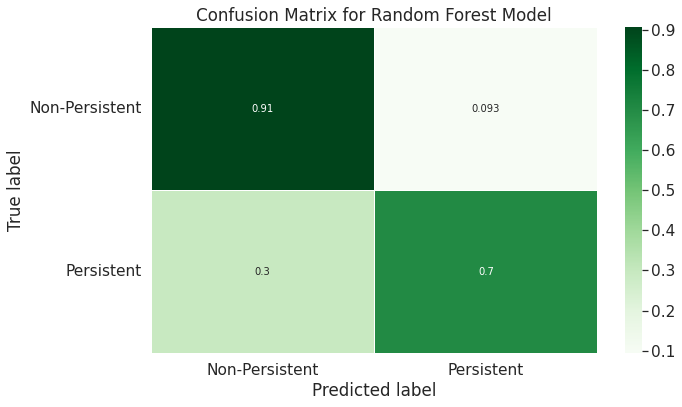

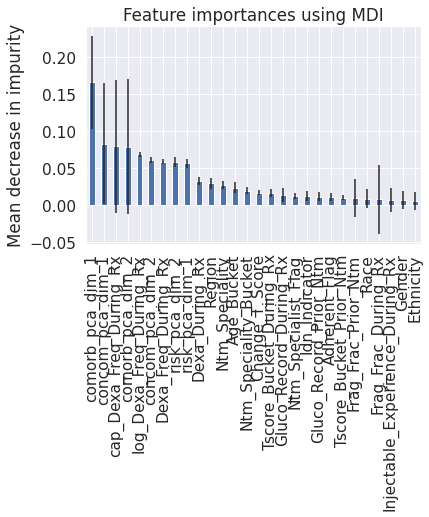

In [ ]:
model=model_train(df[inde_colnames_1])

plot_feature_importances(model)

{'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 145, 'random_state': 265}
train set acc: 0.8714859437751004 test set acc: 0.8306569343065694

Confusion matrix: 
[[379  39]
 [ 77 190]]
                precision    recall  f1-score   support

Non-Persistent       0.83      0.91      0.87       418
    Persistent       0.83      0.71      0.77       267

      accuracy                           0.83       685
     macro avg       0.83      0.81      0.82       685
  weighted avg       0.83      0.83      0.83       685



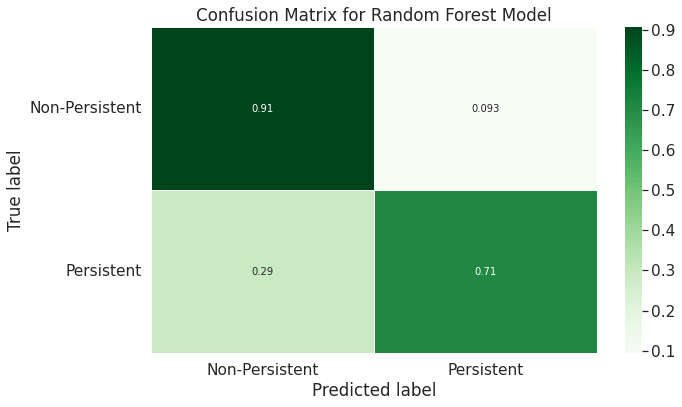

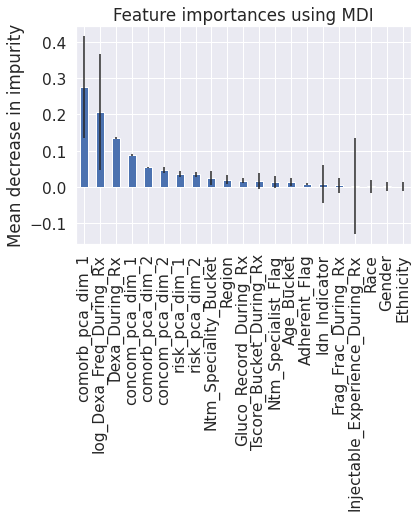

In [ ]:
param_grid = {
        'n_estimators': list(range(5,150,10)),
        'criterion':["gini", "entropy", "log_loss"],
        'max_depth': [2, 5, 7, 11, 15],
        'max_features':['sqrt', 'log2', None],
        'min_samples_leaf':list(range(1,20,5)),
        'random_state': [265]
}


rf=RandomForestClassifier()

best_model=model_train_cv(df[inde_colnames_1],rf,param_grid)

plot_feature_importances(best_model)